# 1 Predicting Gender of Brazilian Names Using Deep Learning in Data Lattes

## 1.1 Necessary libraries

In [1]:
get_ipython().magic('reset -sf')

In [2]:
import numpy as np
import pandas as pd
from joblib import dump, load
from tensorflow import keras
from unidecode import unidecode
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from keras.layers import Dense, LSTM, Bidirectional, Activation

2021-12-04 21:32:23.277906: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-04 21:32:23.277934: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## 1.2 Read the dataset

In [3]:
DataSEMISH = pd.read_csv(r"../data-from-SEMISH/dataSEMISH.csv")

In [4]:
DataSEMISH.head()

,Ano,Autor,Primeiro Nome,Titulos
0,2021,Jean Moraes,Jean,Implementação de um cluster Kubernetes com a p...
1,2021,Elen Lobato,Elen,Implementação de um cluster Kubernetes com a p...
2,2021,Denis Rosário,Denis,Implementação de um cluster Kubernetes com a p...
3,2021,Ubiratan Bezerra,Ubiratan,Implementação de um cluster Kubernetes com a p...
4,2021,Eduardo Cerqueira,Eduardo,Implementação de um cluster Kubernetes com a p...


In [5]:
print("Names : " + str(len(DataSEMISH["Primeiro Nome"])))

Names : 334


### 1.2.1 Preparing the data

In [6]:
data = DataSEMISH["Primeiro Nome"].apply(unidecode).apply(str.lower).apply(lambda x: x.replace("."," "))

## 1.3 Encoding Words

In [7]:
#word encoding
maxlen = 20                                               # max lenght of a name

'''Define a vocabulary which corresponds to all the unique letters encountered'''
vocab = set(' '.join([str(i) for i in data]))            # creating a vocab
vocab.add('END')
len_vocab = len(vocab)

char_index = dict((c, i) for i, c in enumerate(vocab))    # creating a dictionary
''' The dictionary maps each letter of vocabulary to a number '''

# Builds an empty line with a 1 at the index of character
def set_flag(i):
    aux = np.zeros(len_vocab);
    aux[i] = 1
    return list(aux)

# Truncate names and create the matrix
def prepare_encod_names(X):
    vec_names = []
    trunc_name = [str(i)[0:maxlen] for i in X]  # consider only the first 20 characters
    for i in trunc_name:
        tmp = [set_flag(char_index[j]) for j in str(i)]
        for k in range(0,maxlen - len(str(i))):
            tmp.append(set_flag(char_index["END"]))
        vec_names.append(tmp)
    return vec_names

'''This is called one-hot-encoder and is based on the following papers: 
https://arxiv.org/abs/1707.07129 : Predicting the gender of Indonesian names
https://ieeexplore.ieee.org/document/8560790 : Advance Gender Prediction Tool...
 '''

'This is called one-hot-encoder and is based on the following papers: \nhttps://arxiv.org/abs/1707.07129 : Predicting the gender of Indonesian names\nhttps://ieeexplore.ieee.org/document/8560790 : Advance Gender Prediction Tool...\n '

In [8]:
x = prepare_encod_names(data)

## 1.4 BiLSTM Model

In [9]:
bilstm = keras.Sequential()
bilstm.add(Bidirectional(LSTM(128, return_sequences=False, dropout=0.2, recurrent_dropout=0.2), 
                            backward_layer=LSTM(128, return_sequences=False, go_backwards=True, dropout=0.2, recurrent_dropout=0.2),
                            input_shape=(maxlen,len_vocab)))
bilstm.add(Dense(1, activity_regularizer=l2(0.002)))
bilstm.add(Activation('sigmoid'))

2021-12-04 21:32:34.649905: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-04 21:32:34.649935: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-04 21:32:34.649964: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (default): /proc/driver/nvidia/version does not exist
2021-12-04 21:32:34.650188: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
bilstm.load_weights(filepath=r"../machine-learning-models/deep-learning-models/BiLSTM/Model/BiLSTM.hdf5")

## 1.5 Predict Gender

In [11]:
resu=(bilstm.predict(x) > 0.5).astype("int32")

#### 1.5.1 Analysis of results

In [12]:
DataSEMISH["BiLSTM"] = resu
DataSEMISH.sort_values("Ano", inplace=True)
DataSEMISH

,Ano,Autor,Primeiro Nome,Titulos,BiLSTM
333,2018,Leonardo Cunha de Miranda,Leonardo,Sustentabilidade de Foto-memórias na Era Digit...,0
309,2018,Gabriel Oliveira Ferreira,Gabriel,"Controladores, tratamento de sinais e programa...",1
308,2018,Ricardo Reis,Ricardo,Estratégias para a Redução de Consumo de Energ...,0
307,2018,Paulo F. Pires,Paulo,Classifying Smart IoT Devices for Running Mach...,0
306,2018,Flávia C. Delicato,Flávia,Classifying Smart IoT Devices for Running Mach...,1
...,...,...,...,...,...
89,2021,Larissa Mukuno,Larissa,Aplicando modelo de aprendizagem supervisionad...,0
88,2021,Renato Hidaka Torres,Renato,Análise de sentimento com rede neural convoluc...,0
87,2021,Orlando Shigueo Ohashi Junior,Orlando,Análise de sentimento com rede neural convoluc...,1
93,2021,Edleno Silva de Moura,Edleno,Jusbrasil e os Desafios Tecnológicos para Faci...,0


In [13]:
data = dict()
F = 0
M = 0
ant = 2018
for ano, classi in zip(DataSEMISH["Ano"], DataSEMISH["BiLSTM"]):
    if ant != ano and ant != 0:
        data[ant] = [F, M]
        F, M = 0, 0
        ant = ano
    if classi == 1:
        F += 1
    if classi == 0:
        M += 1
data[ant] = [F, M]
print(data)

{2018: [5, 36], 2019: [10, 55], 2020: [21, 72], 2021: [24, 111]}


In [14]:
dftmp = pd.DataFrame()
dftmp["Ano"] = [x for x in data]
dftmp["M"] = [data[x][1] for x in data]
dftmp["F"] = [data[x][0] for x in data]
dftmp.set_index("Ano", inplace=True)

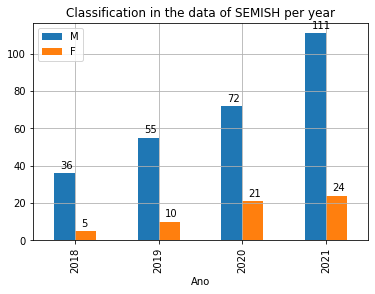

In [15]:
ax = dftmp.plot(kind="bar")
plt.title("Classification in the data of SEMISH per year")
plt.grid('True')
plt.xlabel('Ano')
x_offset = -0.05
y_offset = 2.5
for p in ax.patches:
    b = p.get_bbox()
    val = "{:.0f}".format(b.y1 + b.y0)        
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))

<AxesSubplot:title={'center':'Classification in the data of SEMISH per year'}, xlabel='Ano'>

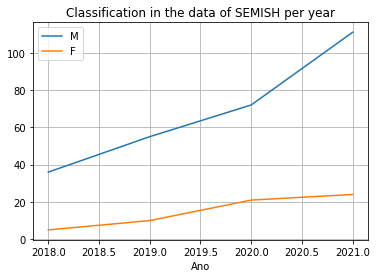

In [16]:
dftmp.plot.line(grid=True, title="Classification in the data of SEMISH per year")